# Vorhersage der Kundenakquisition für Festgelder

In dieser Analyse untersuchen wir einen Datensatz, der Informationen über Marketingkampagnen einer Bank enthält. Ziel ist es, ein Modell zu entwickeln, das vorhersagen kann, ob ein Kunde ein Festgeldkonto abschließen wird oder nicht.

Wir gehen wie folgt vor:
1. **Datenverständnis**: Wir analysieren die Struktur und den Inhalt des Datensatzes, um ein Verständnis für die verfügbaren Merkmale und sinnvolle Evaluierungs-Metriken zu gewinnen.
2. **Datenaufbereitung**: Wir bereiten die Daten für die Modellierung vor, indem wir sie für das Training und die Evaluation aufteilen und entsprechende Transformationen durchführen.
3. **Modellierung**: Wir trainieren ein Benchmark-Modell und vergleichen dieses mit einem Random Forest Modell, um einen ersten Eindruck der Vorhersageleistung und Wichtigkeit der Merkmale zu erhalten.
4. **Evaluierung**: Wir bewerten die Modelle anhand geeigneter Metriken, um deren Leistungsfähigkeit der Prognose beurteilen zu können.
5. **Fazit**: Wir fassen die Ergebnisse zusammen und geben Empfehlungen für weitere Schritte zur Verbesserung der Vorhersagegenauigkeit.

## Setup

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
)
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Vor der Analyse müssen wir die Daten laden. Ein Split in Trainings- und Testdaten ist ebenfalls notwendig, um die Modelle später zu evaluieren und Data Leakage bereits während der explorativen Datenanalyse zu vermeiden.

In [2]:
df = pd.read_csv("data/bank-additional-full.csv", sep=";")

X = df.drop(columns=["y"])
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

## Explorative Datenanalyse

### Wie sind die Daten strukturiert?

In [3]:
df_train.head(n=10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,35,entrepreneur,married,high.school,no,no,no,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,22,services,single,professional.course,no,no,no,cellular,jul,tue,...,3,999,1,failure,-1.7,94.215,-40.3,0.835,4991.6,yes
2,38,blue-collar,married,unknown,no,yes,no,telephone,jun,fri,...,5,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
3,25,blue-collar,single,basic.9y,unknown,yes,no,cellular,jul,wed,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
4,37,technician,married,university.degree,no,no,no,cellular,aug,wed,...,4,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
5,30,technician,single,university.degree,unknown,yes,no,telephone,may,thu,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,yes
6,30,admin.,single,university.degree,no,yes,no,cellular,jul,thu,...,8,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,yes
7,52,services,married,high.school,no,no,no,telephone,may,wed,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
8,33,blue-collar,single,basic.9y,no,yes,yes,cellular,jul,tue,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
9,32,blue-collar,married,basic.4y,unknown,no,yes,cellular,jul,wed,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32950 non-null  int64  
 1   job             32950 non-null  object 
 2   marital         32950 non-null  object 
 3   education       32950 non-null  object 
 4   default         32950 non-null  object 
 5   housing         32950 non-null  object 
 6   loan            32950 non-null  object 
 7   contact         32950 non-null  object 
 8   month           32950 non-null  object 
 9   day_of_week     32950 non-null  object 
 10  duration        32950 non-null  int64  
 11  campaign        32950 non-null  int64  
 12  pdays           32950 non-null  int64  
 13  previous        32950 non-null  int64  
 14  poutcome        32950 non-null  object 
 15  emp.var.rate    32950 non-null  float64
 16  cons.price.idx  32950 non-null  float64
 17  cons.conf.idx   32950 non-null 

In [5]:
df_train.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.014932,258.566161,2.557360,962.414325,0.172838,0.090734,93.577104,-40.483005,3.632576,5167.523250
std,10.407901,259.417876,2.720866,187.062931,0.493937,1.569535,0.578993,4.622691,1.730625,71.969364
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
df_train.describe(include=["object"])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,8351,19987,9718,26021,17214,27164,20941,10982,6896,28441,29250


In [7]:
for col in df_train.select_dtypes(include=["object"]).columns:
    print(f"{df_train[col].value_counts()}")
    print("\n" + "-" * 40 + "\n")

job
admin.           8351
blue-collar      7379
technician       5430
services         3189
management       2324
retired          1371
entrepreneur     1161
self-employed    1127
housemaid         842
unemployed        810
student           705
unknown           261
Name: count, dtype: int64

----------------------------------------

marital
married     19987
single       9213
divorced     3684
unknown        66
Name: count, dtype: int64

----------------------------------------

education
university.degree      9718
high.school            7651
basic.9y               4828
professional.course    4228
basic.4y               3324
basic.6y               1815
unknown                1372
illiterate               14
Name: count, dtype: int64

----------------------------------------

default
no         26021
unknown     6926
yes            3
Name: count, dtype: int64

----------------------------------------

housing
yes        17214
no         14946
unknown      790
Name: count, dtype: int6

### Sind fehlende Werte vorhanden?

Es sind keine fehlenden Werte als solche in den Daten vorhanden. Wie im letzten Abschnitt zu sehen ist jedoch bei einigen Kategorien, wie zum "job" und "education", ein Eintrag "unknown" vorhanden, der als expliziter fehlender Wert interpretiert werden kann.

In [9]:
df_train.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [10]:
df_train[df_train["pdays"] == -1].shape

(0, 21)

### Sind Duplikate vorhanden?

In den Daten finden sich 7 Duplikate, die insgesamt 14 Reihen ausmachen. Da basierend auf den vorhandenen Spalten auch mehrmals Einträge mit denselben Werten vorkommen können, lassen wir diese vorerst im Datensatz.

In [11]:
df_train.duplicated().sum()

np.int64(7)

In [12]:
df_train[df_train.duplicated(keep=False)].sort_values(by=df_train.columns.tolist())

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
15653,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16484,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
9239,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
16821,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
11524,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
12214,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
6624,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
20903,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
3703,45,admin.,married,university.degree,no,no,no,cellular,jul,thu,...,1,999,0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,yes
7789,45,admin.,married,university.degree,no,no,no,cellular,jul,thu,...,1,999,0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,yes


### Wie ist die Zielvariable verteilt?

Die Zielvariable ist stark unausgeglichen, mit ca. 88% "no" und 12% "yes" Einträgen im Trainingsdatensatz. Dies muss bei der Evaluation der Modelle berücksichtigt werden und legt den Einsatz von Metriken wie dem F1-Score nahe, da durch die Ungleichverteilung eine hohe Genauigkeit (Accuracy) erreicht werden kann, ohne dass das Modell tatsächlich aus den Daten lernt.

Der F1-Score hingegen berücksichtigt sowohl Precision (Wie viele der als "yes" vorhergesagten Fälle sind tatsächlich "yes"?) als auch Recall (Wie viele der tatsächlichen "yes"-Fälle wurden erkannt?) und bietet somit eine ausgewogenere Bewertung der Modellleistung bei unausgeglichenen Datensätzen.

In [13]:
df_train["y"].value_counts(normalize=True).round(4)

y
no     0.8877
yes    0.1123
Name: proportion, dtype: float64

In [14]:
def plot_countplot(data, column, title="Countplot"):
    sns.countplot(x=column, data=data)
    plt.title(f"Count of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

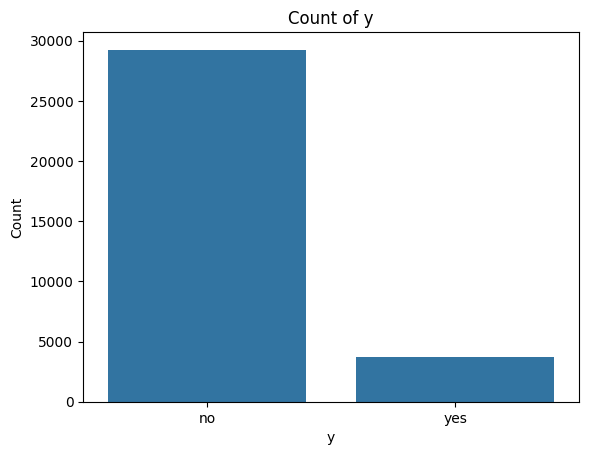

In [15]:
plot_countplot(df_train, "y")

### Wie sind die numerischen Merkmale verteilt?

Es ist zu beobachten, dass die numerischen Spalten häufiger stark rechts-schief verteilt sind (z.B. "duration", "campaign", "previous"), da die meisten Kunden weniger häufig kontaktiert wurden und nur wenige Kunden sehr oft. Andere Merkmale wie "age" oder "balance" weisen eine annähernd normalverteilte Form auf, während ökonomische Merkmale wie emp.var.rate oder cons.price.idx eine Verteilung mit mehreren Spitzen aufweisen.

Ein Blick auf die Korrelationen zwischen den numerischen Merkmalen zeigt, dass eine starke Korrelation zwischen ökomomischen Merkmalen wie emp.var.rate, emp.var.rate und euribor3m besteht. Dies sollte bei der Modellierung berücksichtigt werden.

In [28]:
def plot_numerical_overview(df, column, target):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    sns.histplot(df[column], kde=True, ax=ax1)
    sns.despine(ax=ax1)
    ax1.set_xlabel(column)
    ax1.set_ylabel("Häufigkeit")
    ax1.set_title(f"{column} x Häufigkeit")

    sns.violinplot(x=target, y=column, data=df, split=True, ax=ax2)
    ax2.set_xlabel(target)
    ax2.set_ylabel(column)
    ax2.set_title(f"{column} Verteilung nach {target}")

    plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
    plt.show()

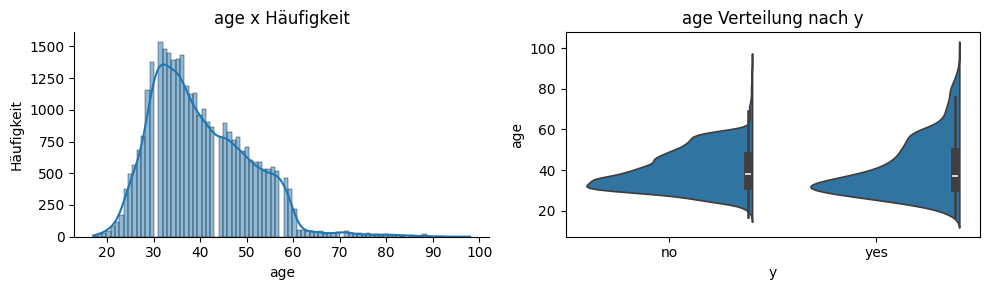

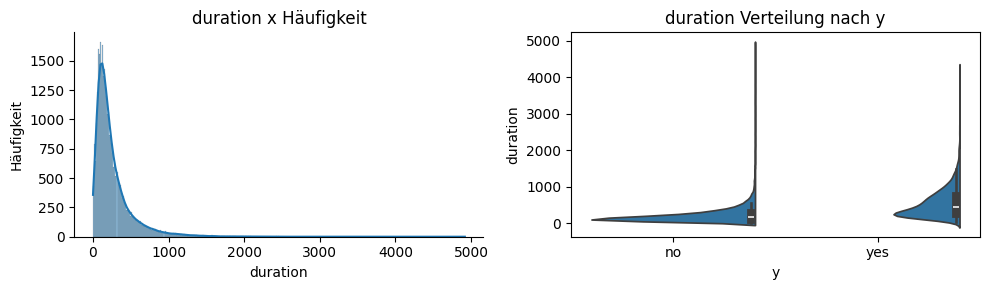

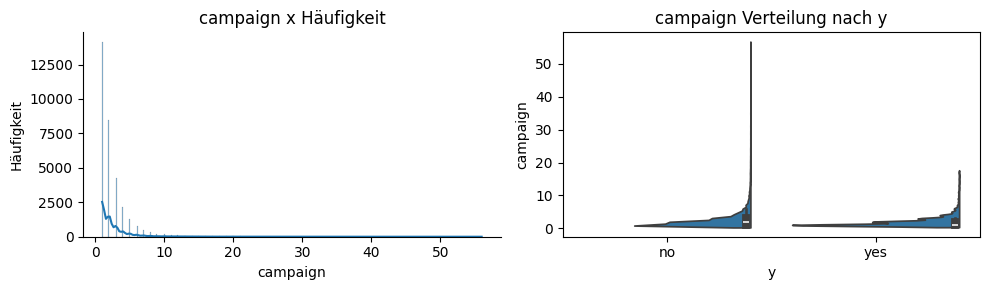

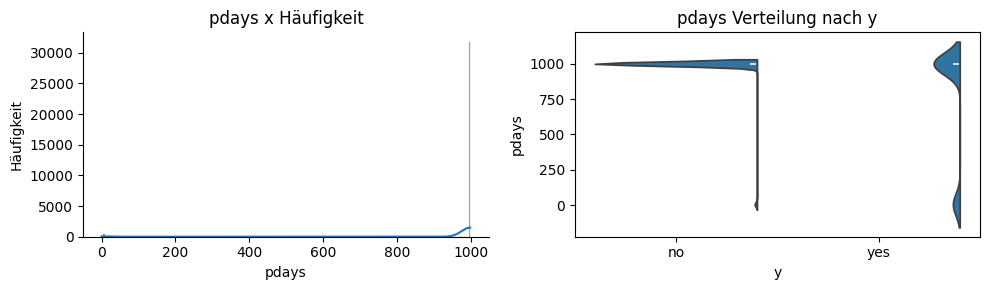

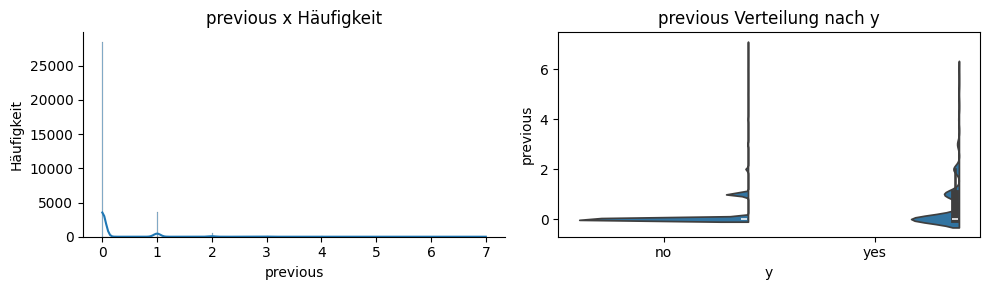

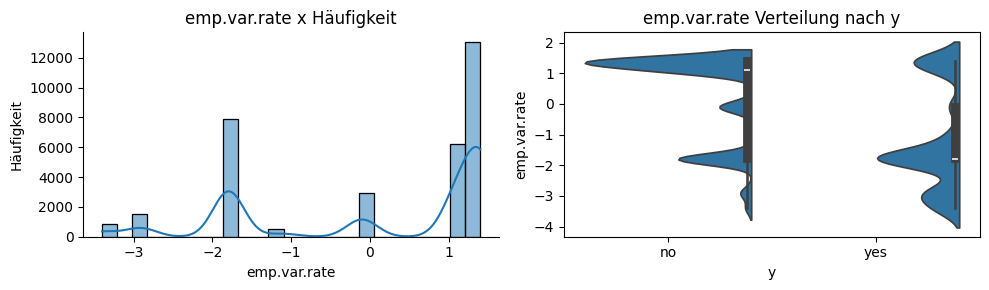

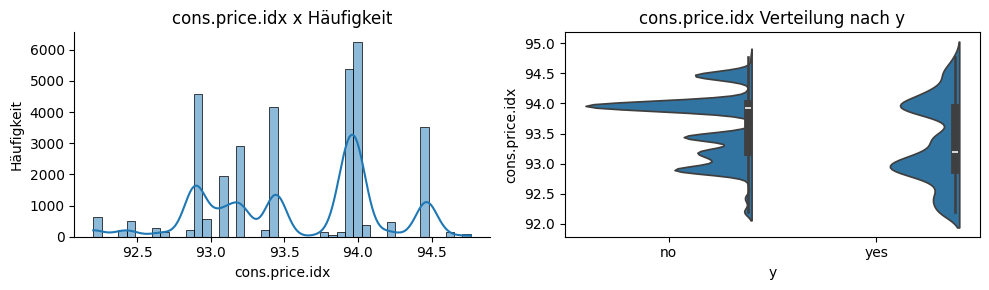

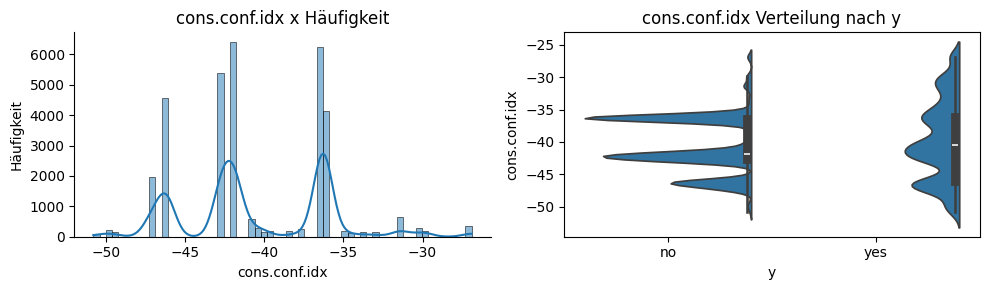

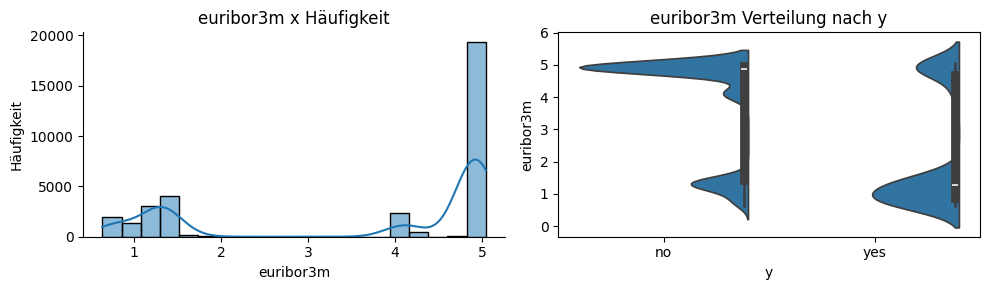

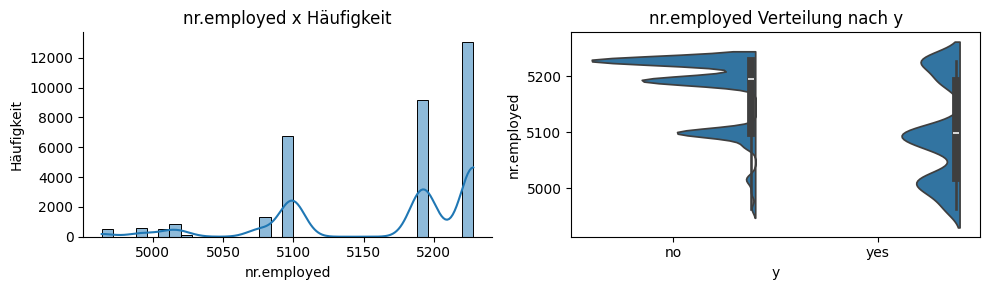

In [29]:
numerical_columns = df_train.select_dtypes(include=["int64", "float64"]).columns

for col in numerical_columns:
    plot_numerical_overview(df_train, col, "y")

Die Spalte "pdays" enthält sehr viele Reihen mit dem Wert 999. Dies könnte darauf hindeuten, dass dieser Wert als Platzhalter für "nicht kontaktiert" verwendet wird. In der Beschreibung des Datensatzes wird jedoch der Wert "-1" für diesen Zweck angegeben. Dies sollte nochmals besprochen werden. Vorerst wird die Spalte "pdays" aufgrund diesr Unklarheit aus der Analyse ausgeschlossen.

In [30]:
df_train["pdays"].value_counts().sort_values(ascending=False)

pdays
999    31736
3        354
6        324
4         92
7         54
9         51
2         48
12        46
10        42
5         38
13        32
11        21
1         20
14        19
15        18
0         14
8         14
16         7
17         6
18         5
19         3
22         2
25         1
21         1
27         1
26         1
Name: count, dtype: int64

In [39]:
def plot_correlation_heatmap(df):
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Korrelationen numerischer Merkmale")
    plt.show()

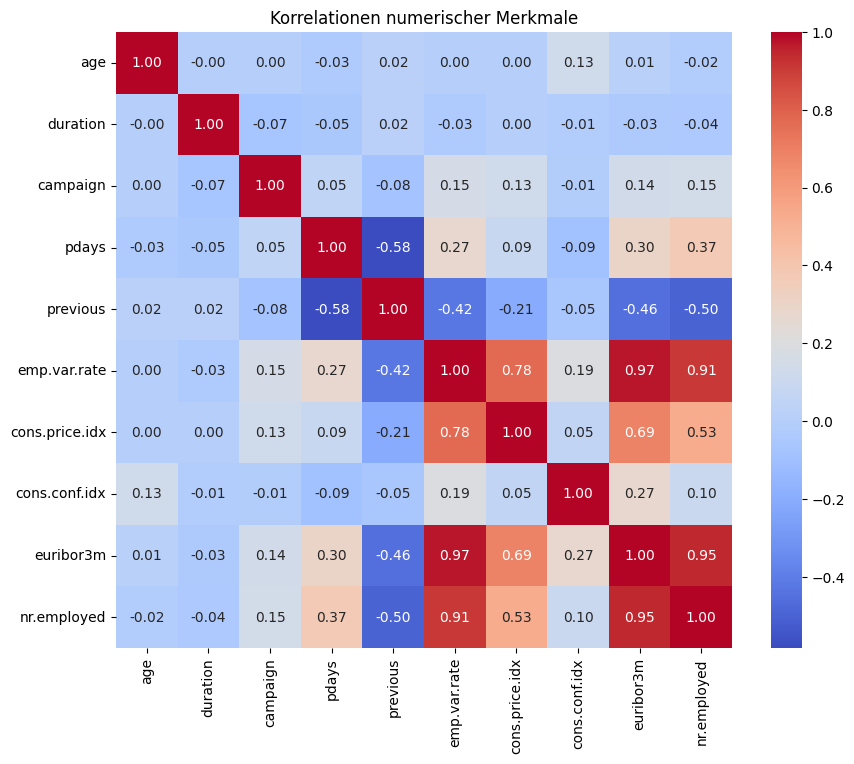

In [40]:
plot_correlation_heatmap(df_train[numerical_columns])

### Wie sind die kategorischen Merkmale verteilt?

Die kategorischen Merkmale weisen unterschiedliche Verteilungen auf. Einige Kategorien, wie "marital" und "default", sind relativ ausgewogen verteilt, während andere, wie "job" und "education", eine starke Dominanz bestimmter Klassen aufweisen. Dies könnte Auswirkungen auf die Modellierung haben, insbesondere wenn bestimmte Klassen unterrepräsentiert sind. 

Beim Blick auf die Aufspaltungen nach der Zielvariable "y" zeigen sich ebenfalls Unterschiede in den Verteilungen, die auf potenzielle Zusammenhänge zwischen den Merkmalen und der Zielvariable hinweisen könnten. Jedoch sind einige Fälle, in welchen "yes" häufiger vorkommt, sehr selten, was die Aussagekraft dieser Beobachtungen einschränkt.

In [68]:
def plot_categorical_overview(df, column, target):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    sns.countplot(x=column, data=df, ax=ax1)
    ax1.set_xlabel(column)
    ax1.set_ylabel("Häufigkeit")
    ax1.set_title(f"Häufigkeit von {column}")
    plt.setp(ax1.get_xticklabels(), rotation=90)

    target_crosstab = pd.crosstab(df[column], df[target], normalize="index")
    sns.heatmap(target_crosstab, annot=True, fmt=".2f", cmap="Blues", ax=ax2)
    ax2.set_xlabel(target)
    ax2.set_ylabel(column)
    ax2.set_title(f"{column} vs. {target}")
    plt.setp(ax2.get_yticklabels(), rotation=0)

    plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
    plt.show()

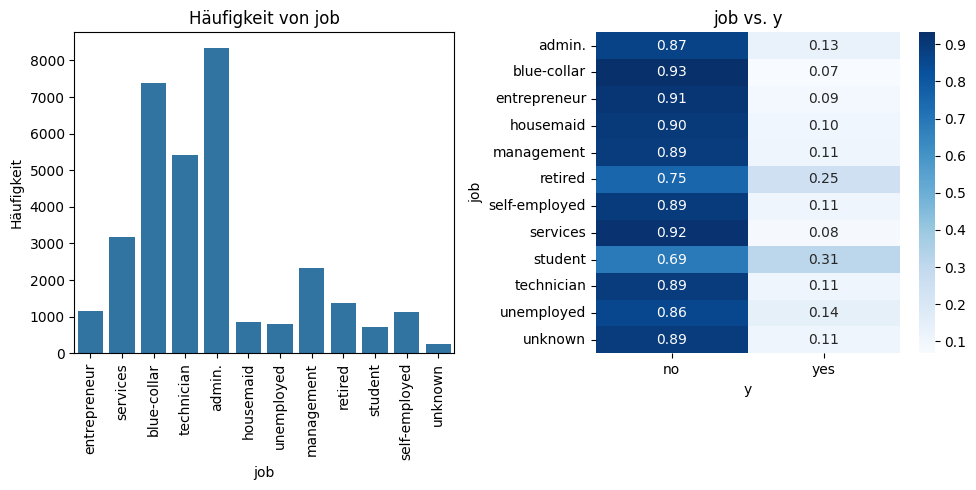

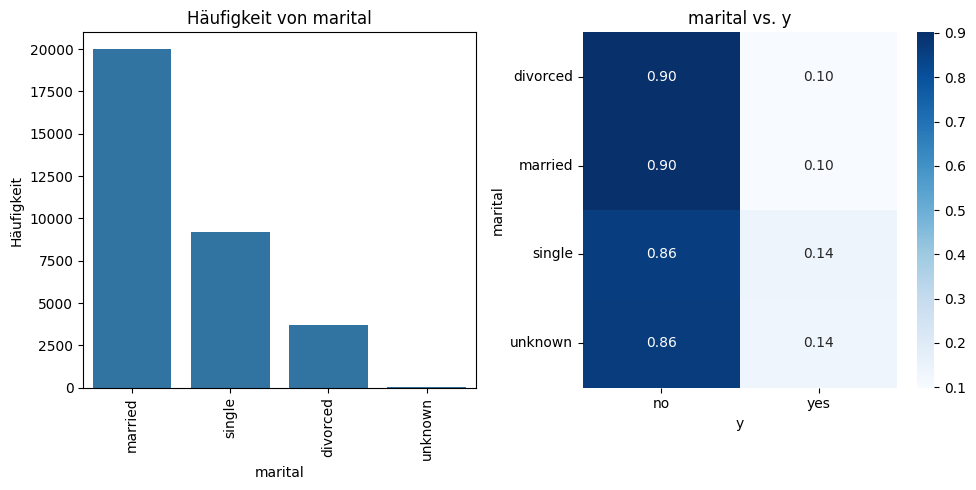

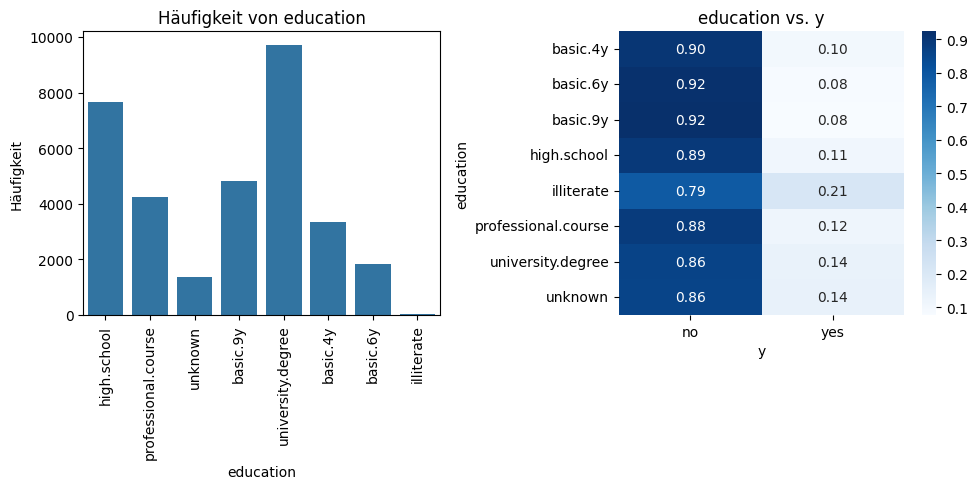

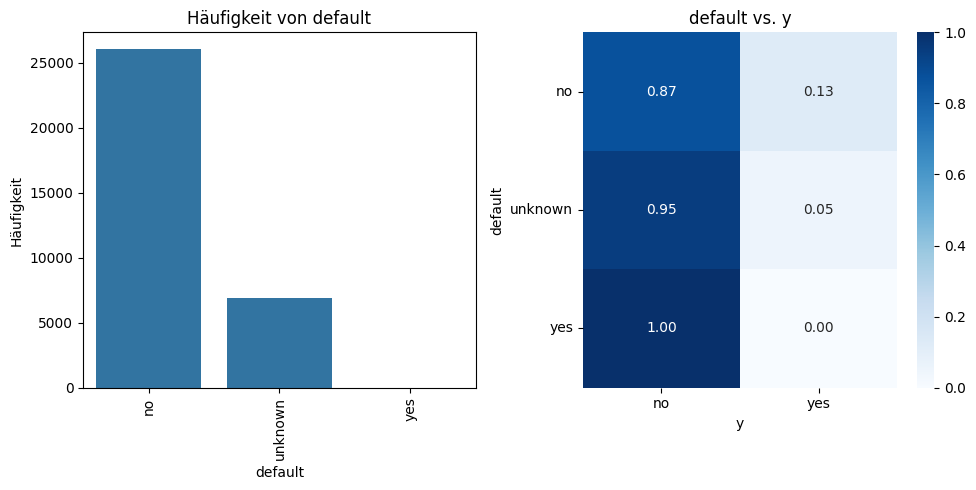

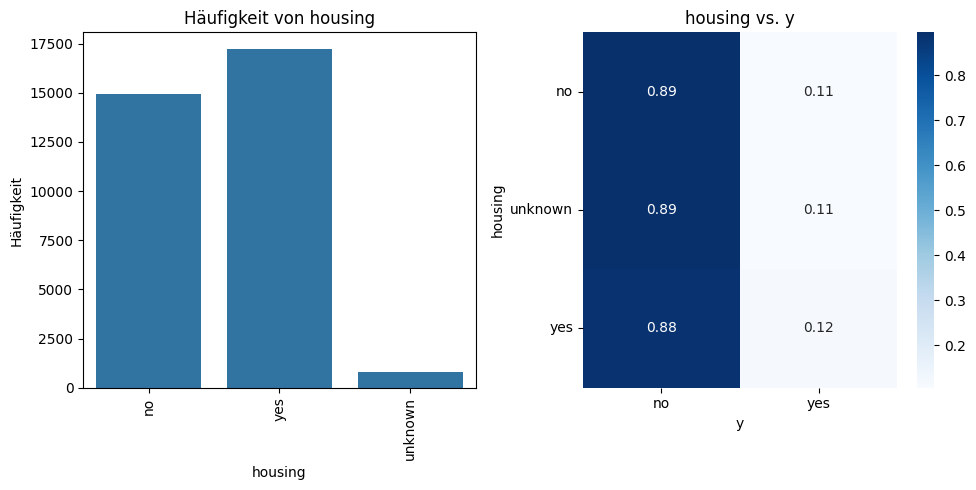

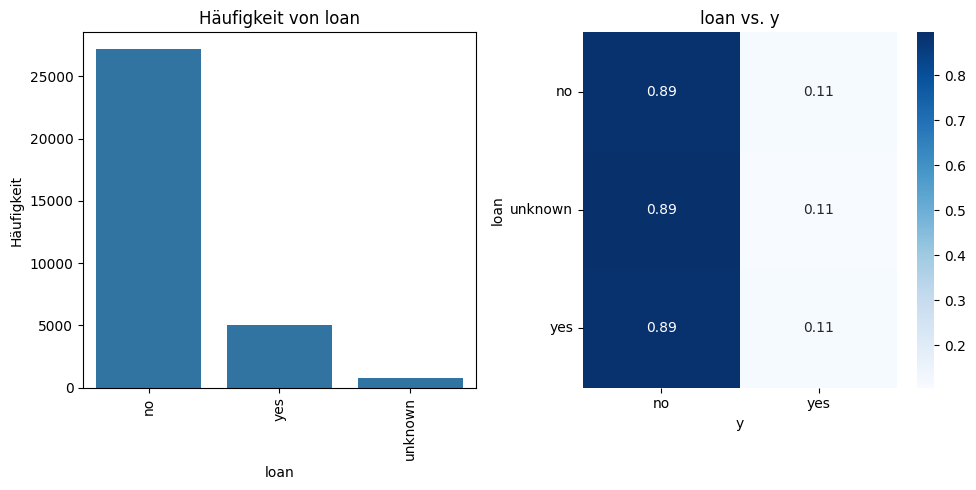

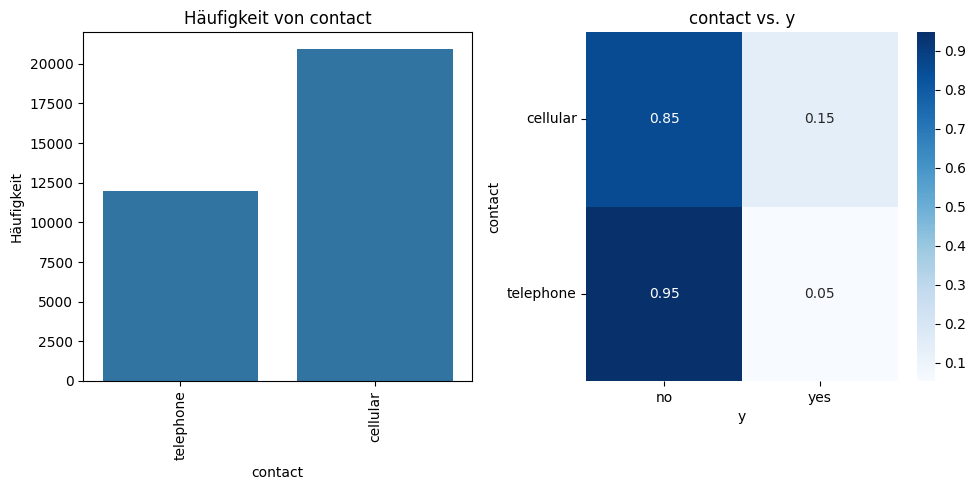

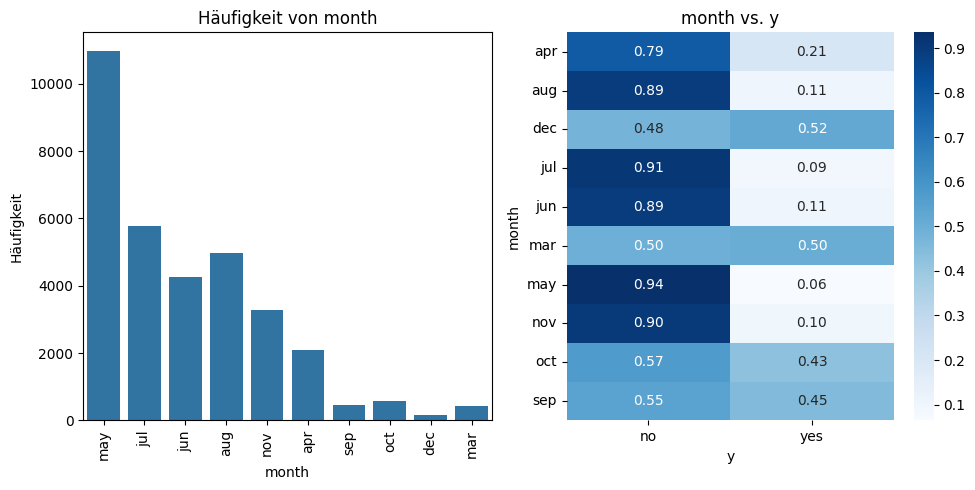

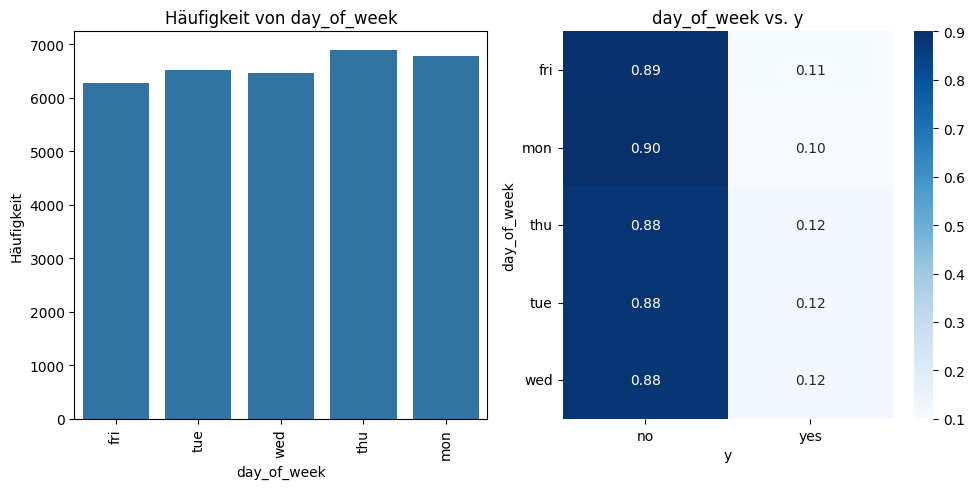

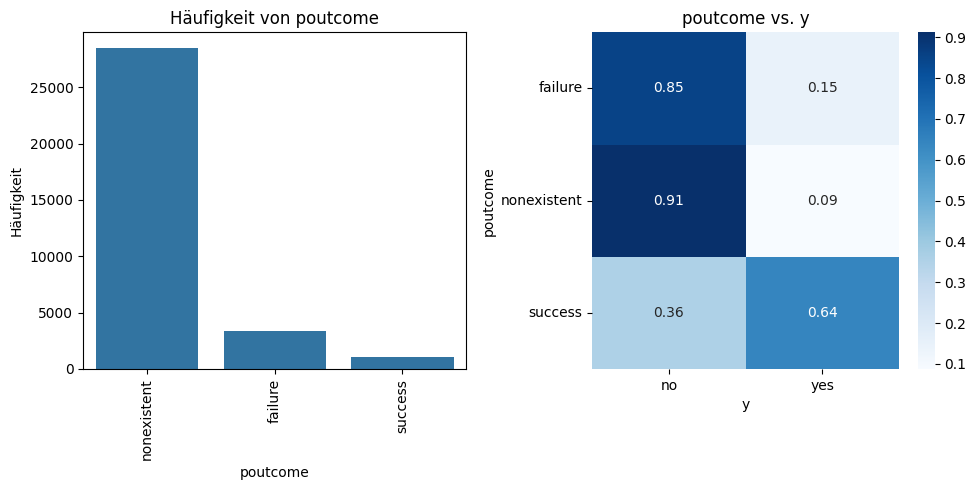

In [69]:
categorical_columns = df_train.select_dtypes(include=["object"]).columns.drop("y")
for col in categorical_columns:
    plot_categorical_overview(df_train, col, "y")

## Modellierung

### Vorbereitung der Daten

Um die Daten für die Modellierung vorzubereiten, müssen wir zunächst die kategorischen Merkmale in ein geeignetes Format umwandeln. Hierfür verwenden wir einen MinMax-Scaler für die numerischen Merkmale und One-Hot-Encoding für die kategorischen Merkmale. Zudem wird die Zielvariable in binäre Werte umgewandelt (0 für "no" und 1 für "yes"). Die Spalte "pdays" wird aufgrund der oben erklärten Unklarheit aussortiert. Die Spalte "duration" hingegen aufgrund der in der Daten-Dokumentation beschriebenen Problematik.

Die Transformationen werden ausschließlich auf den Trainingsdaten gelernt und anschließend auf die Testdaten angewendet, um Data Leakage zu vermeiden.

In [50]:
y_train = y_train.map({"no": 0, "yes": 1})
y_test = y_test.map({"no": 0, "yes": 1})

X_train = X_train.drop(columns=["duration", "pdays"])
X_test = X_test.drop(columns=["duration", "pdays"])

numerical_features = X_train.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),
        (
            "cat",
            OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"),
            categorical_features,
        ),
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### Training: Entscheidungsbaum als Benchmark

Um einen ersten Eindruck der Vorhersageleistung zu erhalten, trainieren wir einen einfachen Entscheidungsbaum als Benchmark-Modell. Dieser ist anders als z.B. eine logistische Regression auch robuster gegenüber der festgestellten Multikollinearität oder rechtsschiefer Verteilungen.

In [51]:
dt_model = DecisionTreeClassifier(random_state=123, max_depth=5)
dt_model.fit(X_train_transformed, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,123
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


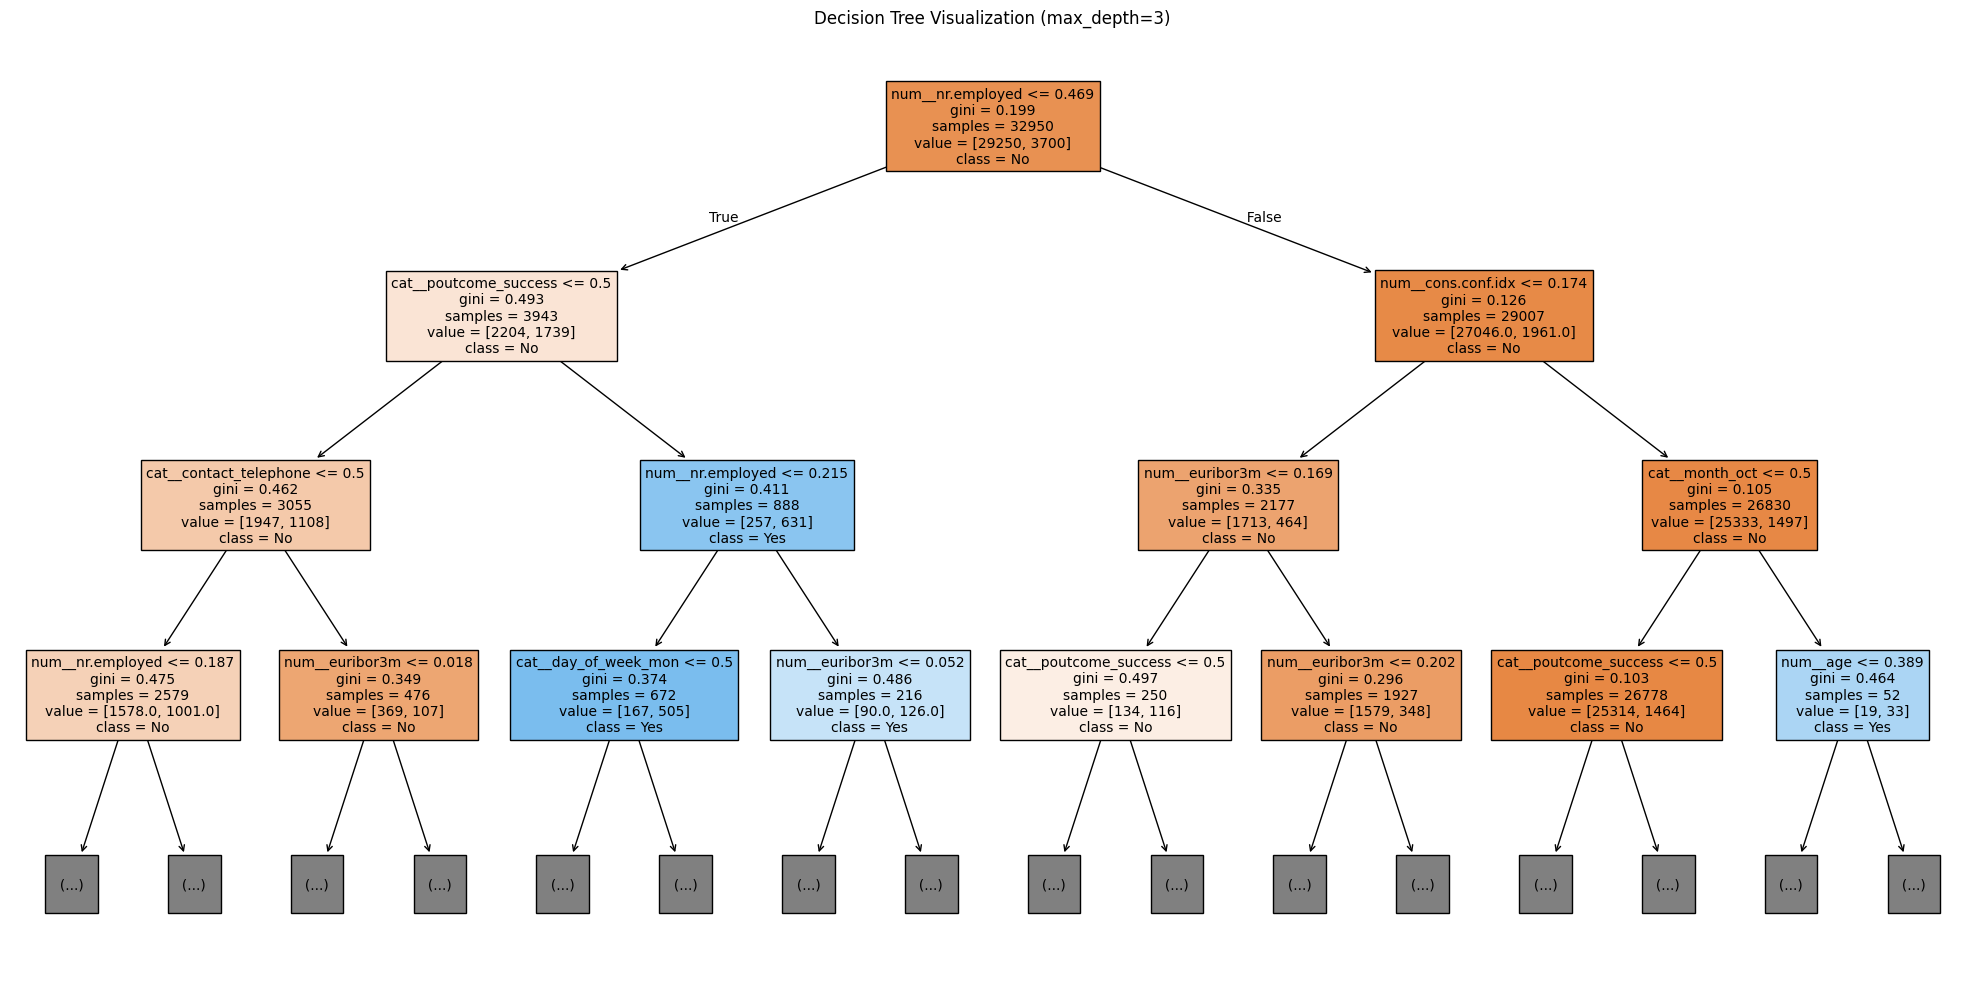

In [77]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    max_depth=3,
    filled=True,
    feature_names=preprocessor.get_feature_names_out(),
    class_names=["No", "Yes"],
    fontsize=10,
)
plt.title("Decision Tree Visualization (max_depth=3)")
plt.tight_layout()
plt.show()

### Training: Random Forest

Um einschätzen zu können, ob ein komplexeres Modell die Vorhersageleistung verbessern kann, trainieren wir zusätzlich ein Random Forest Modell zum Vergleich. Zudem lässt sich hiermit auch die Wichtigkeit der Merkmale für die Vorhersage beurteilen.

In [53]:
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=123, n_jobs=-1
)
rf_model.fit(X_train_transformed, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


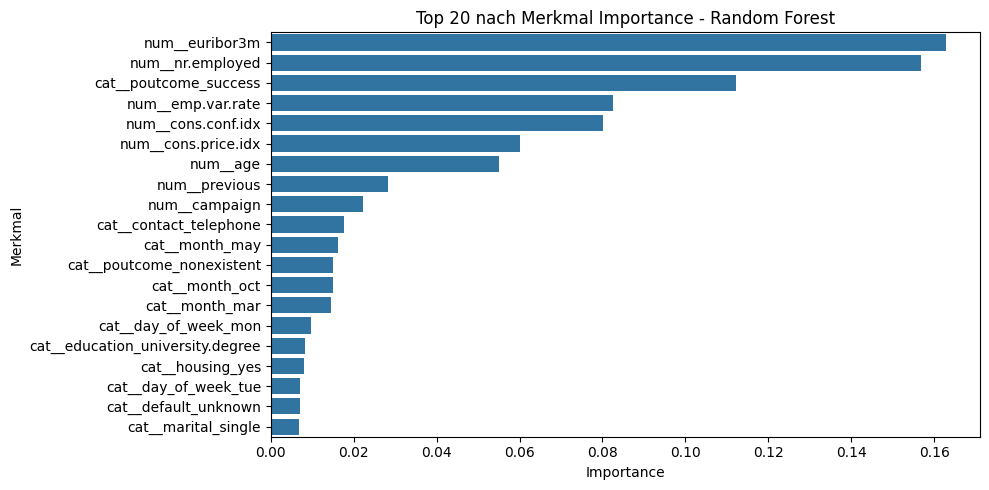

In [59]:
feature_names = preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame(
    {"feature": feature_names, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance.head(20), x="importance", y="feature")
plt.title(f"Top {top_n} nach Merkmal Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Merkmal")
plt.tight_layout()
plt.show()

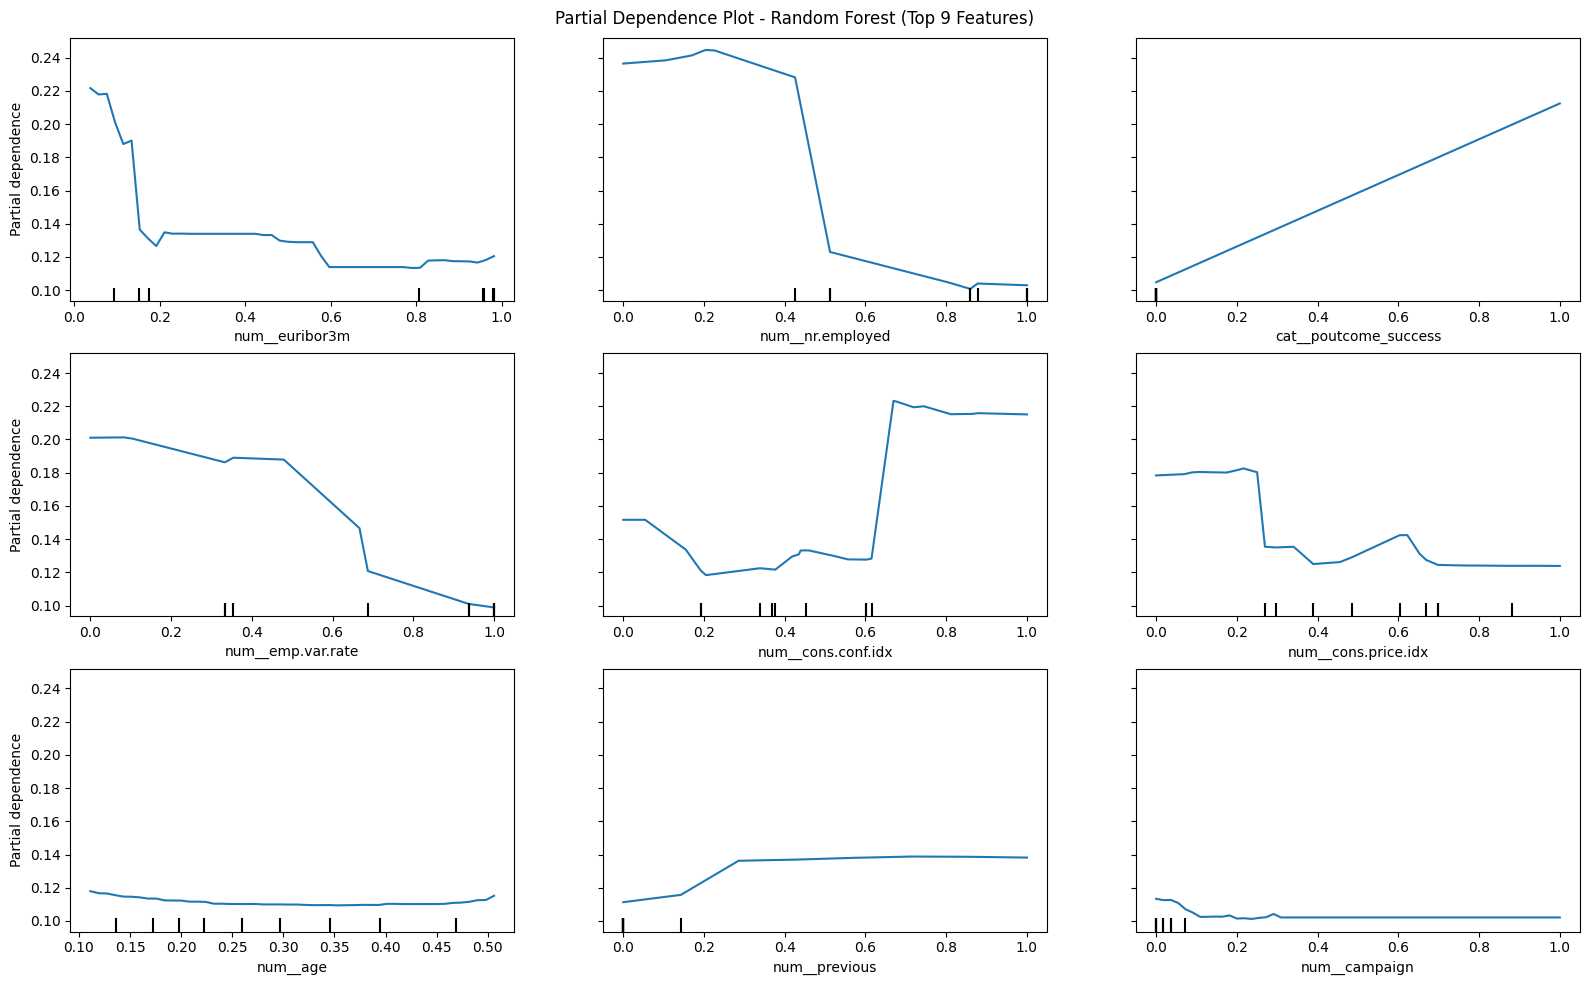

In [79]:
top_features_idx = feature_importance.head(9)["feature"].tolist()
top_features_positions = [list(feature_names).index(feat) for feat in top_features_idx]

fig, ax = plt.subplots(figsize=(16, 10))
PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train_transformed,
    features=top_features_positions,
    feature_names=feature_names,
    target=1,
    grid_resolution=50,
    n_cols=3,
    ax=ax,
)
plt.suptitle(
    "Partial Dependence Plot - Random Forest (Top 9 Features)"
)
plt.tight_layout()
plt.show()

## Evaluierung der Modelle

Die Modelle werden aufgrund der unausgeglichenen Zielvariable anhand des F1-Scores evaluiert, der sowohl Precision als auch Recall berücksichtigt und somit eine ausgewogenere Bewertung der Modellleistung bietet.

Hierbei zeigt sich, dass der Decision Tree mit einem F1-Score von 0.41 einen höheren Wert erreicht als das Random Forest Modell mit einem F1-Score von 0.35. Dies könnte darauf hindeuten, dass das Random Forest Modell möglicherweise überangepasst ist oder dass die Hyperparameter nicht optimal gewählt wurden. Hier sollten weitere Untersuchungen und Optimierungen durchgeführt werden, um die Leistung zu verbessern.

Allgemein weisen die Modelle eine bessere Leistung für die Klasse "no" auf, was angesichts der unausgeglichenen Verteilung der Zielvariable zu erwarten war. Da in diesem Fall ein False Negative (d.h. ein Kunde, der tatsächlich ein Festgeldkonto abschließt, wird nicht erkannt) möglicherweise schwerwiegendere Folgen hat als ein False Positive, ist dies bereits ein positives Zeichen. Dennoch sollten weitere Schritte unternommen werden, um die Erkennung der "yes"-Klasse zu verbessern.

In [85]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    fig, ax = plt.subplots(figsize=(8, 5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

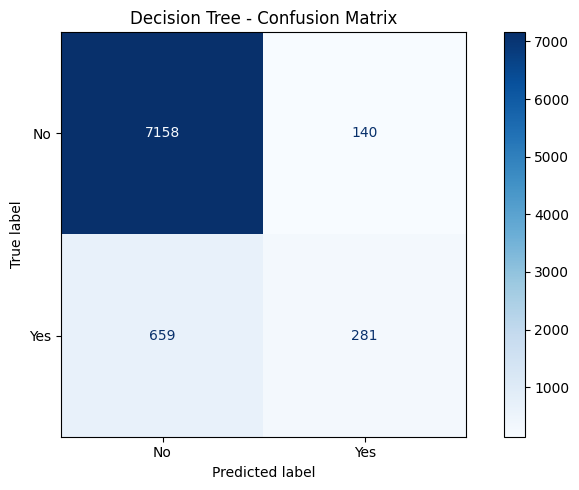

Decision Tree Klassifikations-Metriken:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7298
           1       0.67      0.30      0.41       940

    accuracy                           0.90      8238
   macro avg       0.79      0.64      0.68      8238
weighted avg       0.89      0.90      0.89      8238



In [86]:
y_pred_dt = dt_model.predict(X_test_transformed)

plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")

print("Decision Tree Klassifikations-Metriken:")
print(classification_report(y_test, y_pred_dt))

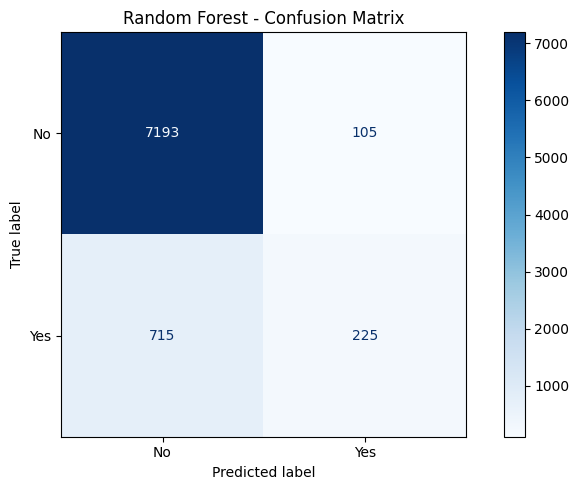

Random Forest Klassifikations-Metriken:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7298
           1       0.68      0.24      0.35       940

    accuracy                           0.90      8238
   macro avg       0.80      0.61      0.65      8238
weighted avg       0.88      0.90      0.88      8238



In [87]:
y_pred_rf = rf_model.predict(X_test_transformed)

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

print("Random Forest Klassifikations-Metriken:")
print(classification_report(y_test, y_pred_rf))

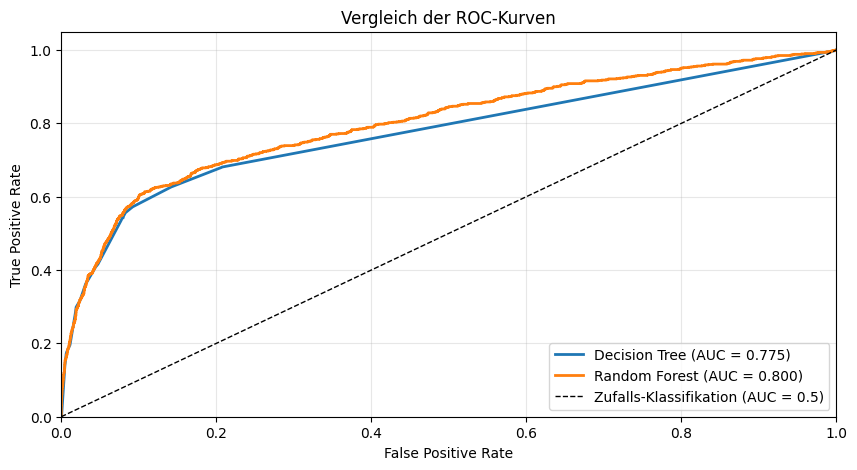

In [88]:
y_pred_dt_proba = dt_model.predict_proba(X_test_transformed)[:, 1]
y_pred_rf_proba = rf_model.predict_proba(X_test_transformed)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)

auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10, 5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.3f})", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Zufalls-Klassifikation (AUC = 0.5)", linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Vergleich der ROC-Kurven")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Zusammenfassung und Ausblick

### Vielversprechende erste Modellierung mit Optimierungspotential

Welche Erkenntnisse konnten gewonnen werden?
- Einfache Modelle wie Entscheidungsbäume können bereits eine solide Vorhersageleistung erzielen, was auf das Potenzial der Daten hinweist.
- Insbesondere ökonomische und kundenspezifische Merkmale scheinen wichtige Prädiktoren für die Zielvariable zu sein.
- Die unausgeglichene Verteilung der Zielvariable (nur wenige Daten für Kunden, die ein Festgeldkonto abschließen) erfordert den Einsatz spezialisierter Metriken wie dem F1-Score zur Bewertung der Modellleistung.
- Das Random Forest Modell zeigte eine geringere Leistung als der Entscheidungsbaum, was auf mögliche Überanpassung oder suboptimale Hyperparameter hindeutet.
- Die bessere Leistung bei der Erkennung der "no"-Klasse im Vergleich zur "yes"-Klasse unterstreicht die Notwendigkeit, die Sensitivität für die "yes"-Klasse zu erhöhen, um potenzielle Kunden besser zu identifizieren. Dies könnte durch Verfahren wie Oversampling oder der Anpassung der Klassengewichte erreicht werden.
- Das Modell erkennt Kunden, die wahrscheinlich keinen vertrag abschließen werden zuverlässiger als potenzielle Interessenten. Um mehr Kunden mit Abschlussinteresse zu identifizieren, sollten wir das Modell gezielt auf diese Gruppe trainieren. Möglichkeiten hierfür sind das (synthetische) Erhöhen positiver Beispiele oder eine stärkere Gewichtung dieser Gruppe.

Was sind potenzielle nächste Schritte?
  - Hyperparameter-Optimierung der bestehenden Modelle.
  - Untersuchung weiterer Algorithmen wie Gradient Boosting oder Support Vector Machines.
  - Implementierung von Techniken zur Behandlung unausgeglichener Datensätze, z.B. SMOTE oder Anpassung der Klassengewichte.
  - Erweiterte Feature-Engineering-Techniken zur Verbesserung der Modellleistung (z.B. Transformationen der Features, genaueres Untersuchen von Interaktionen zwischen Merkmalen, Klären von Unklarheiten wie bei "pdays").

Welche zusätzlichen Daten wären hilfreich?

- Informationen über frühere Interaktionen mit der Bank oder bereits abgeschlossene Produkte.
- Kundenzufriedenheitsbewertungen (z.B. Net Promoter Score, Umfrageergebnisse).
- Sozioökonomische Daten wie Einkommen und Beschäftigungsstatus.
- Zeitliche Daten, die saisonale Trends oder wirtschaftliche Veränderungen berücksichtigen (z.B. Konjunkturzyklen, Arbeitslosenraten).

Wo besteht Potenzial für andere Geschäftsbereiche der Bank?
- Identifikation von Kunden, die für andere Bankprodukte (z.B. Kredite, Kreditkarten) in Frage kommen könnten (ähnliche Prolemstellung wie in dieser Analyse).
- Entwicklung von Modellen zur Vorhersage der Kundenabwanderung und zur Identifikation von Möglichkeiten, wie Kunden gebunden werden können (hierfür muss die Zielvariable entsprechend angepasst werden, z.B. ob ein Kunde innerhalb eines bestimmten Zeitraums die Bank verlässt. Die verwendeten Merkmale könnten jedoch ähnlich bleiben.).